# Vehicle Detection and Tracking

In [257]:
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

## Loading Training Dataset

In [258]:
vehicle_images = glob.glob('dataset/vehicles/**/*.png')
nonvehicle_images = glob.glob('dataset/non-vehicles/**/*.png')
print('Number of vehicle images: ' + str(len(vehicle_images)))
print('Number of non-vehicle images: ' + str(len(nonvehicle_images)))

Number of vehicle images: 8792
Number of non-vehicle images: 8968


## Visualize dataset

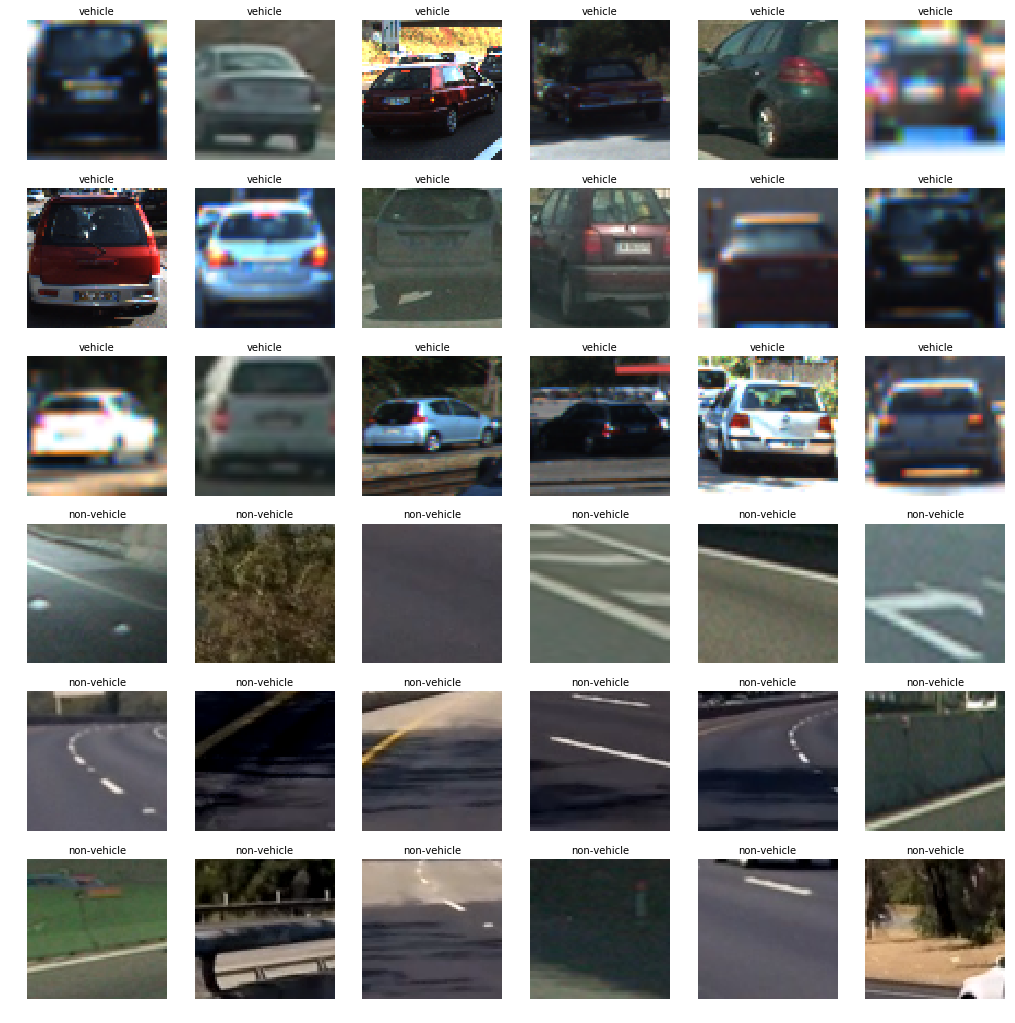

In [259]:
fig, axs = plt.subplots(6,6, figsize=(18, 18))
fig.subplots_adjust(hspace = .2, wspace=.01)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(18):
    img = cv2.imread(vehicle_images[np.random.randint(0,len(vehicle_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('vehicle', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(18,36):
    img = cv2.imread(nonvehicle_images[np.random.randint(0,len(nonvehicle_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-vehicle', fontsize=10)
    axs[i].imshow(img)


## Method for Extracting HOG Features

In [260]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:  
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


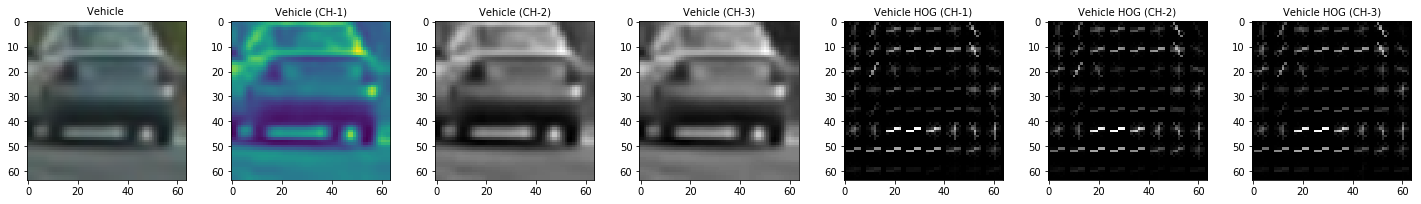

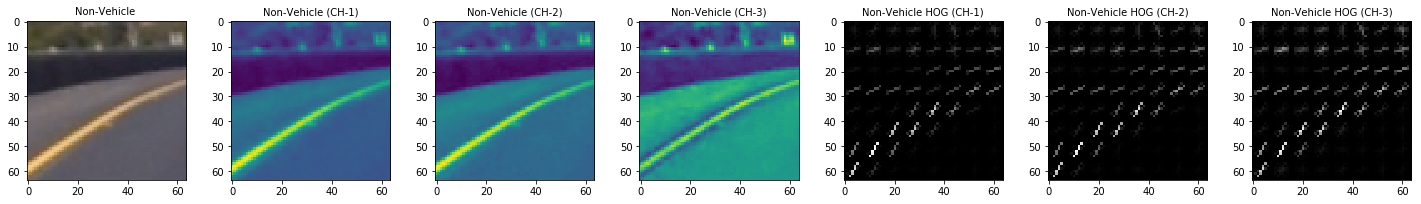

In [261]:
# Visualize HOG on example images
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Vehicle image
vehicle_img = mpimg.imread(vehicle_images[25])
#vehicle_img = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2YUV)
_, vehicle_dst_1 = get_hog_features(vehicle_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, vehicle_dst_2 = get_hog_features(vehicle_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, vehicle_dst_3 = get_hog_features(vehicle_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Non-vehicle image
nonvehicle_img = mpimg.imread(nonvehicle_images[5])
#nonvehicle_img = cv2.cvtColor(nonvehicle_img, cv2.COLOR_RGB2YUV)
_, nonvehicle_dst_1 = get_hog_features(nonvehicle_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, nonvehicle_dst_2 = get_hog_features(nonvehicle_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, nonvehicle_dst_3 = get_hog_features(nonvehicle_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
f, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7, figsize=(20,20))
f.tight_layout()
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle ', fontsize=10)
ax2.imshow(vehicle_img[:,:,0])
ax2.set_title('Vehicle (CH-1)', fontsize=10)
ax3.imshow(vehicle_img[:,:,1], cmap='gray')
ax3.set_title('Vehicle (CH-2)', fontsize=10)
ax4.imshow(vehicle_img[:,:,2], cmap='gray')
ax4.set_title('Vehicle (CH-3)', fontsize=10)
ax5.imshow(vehicle_dst_1, cmap='gray')
ax5.set_title('Vehicle HOG (CH-1)', fontsize=10)
ax6.imshow(vehicle_dst_2, cmap='gray')
ax6.set_title('Vehicle HOG (CH-2)', fontsize=10)
ax7.imshow(vehicle_dst_3, cmap='gray')
ax7.set_title('Vehicle HOG (CH-3)', fontsize=10)

f, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7, figsize=(20,20))
f.tight_layout()
ax1.imshow(nonvehicle_img)
ax1.set_title('Non-Vehicle ', fontsize=10)
ax2.imshow(nonvehicle_img[:,:,0])
ax2.set_title('Non-Vehicle (CH-1)', fontsize=10)
ax3.imshow(nonvehicle_img[:,:,1])
ax3.set_title('Non-Vehicle (CH-2)', fontsize=10)
ax4.imshow(nonvehicle_img[:,:,2])
ax4.set_title('Non-Vehicle (CH-3)', fontsize=10)
ax5.imshow(nonvehicle_dst_1, cmap='gray')
ax5.set_title('Non-Vehicle HOG (CH-1)', fontsize=10)
ax6.imshow(nonvehicle_dst_2, cmap='gray')
ax6.set_title('Non-Vehicle HOG (CH-2)', fontsize=10)
ax7.imshow(nonvehicle_dst_3, cmap='gray')
ax7.set_title('Non-Vehicle HOG (CH-3)', fontsize=10)


## Method for Extracting HOG Features from a List of Images

In [262]:
# Define a function to extract features from a list of images
# This function could also be used to call bin_spatial() and color_hist() to extract
# flattened spatial color features and color histogram features and combine them (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(hog_features)
    
    # Return list of feature vectors
    return features


## Extract HOG Features for Input Datasets, Define Labels Vector, and Split

In [336]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
vehicle_features    = extract_features(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
nonvehicle_features = extract_features(nonvehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Using:',colorspace, 'colorspace, ',orient,'orientations,',pix_per_cell,
    'pixels per cell, and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

48.16 Seconds to extract HOG features...
Using: YUV colorspace,  11 orientations, 16 pixels per cell, and 2 cells per block
Feature vector length: 1188


## Training a Classifier (Support Vector Machine)

In [337]:
# Use a linear SVC (Support Vector Classifier)
svc = LinearSVC()

# Check the training time for the SVC
t1 = time.time()

# Train the SVC
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.04 Seconds to train SVC...
Test Accuracy of SVC =  0.982
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.0023 Seconds to predict 10 labels with SVC


## Method for Using Classifier to Detect Cars in an Image

In [338]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_vehicles(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):

    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Predict using classifier
            test_prediction = svc.predict(hog_features)      
            
            # If positive (prediction == 1) then save the window
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    # Return windows for positive detections           
    return rectangles

## Test Find_Vehicles on an Example Image

In [339]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


## Draw Rectangles

In [340]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


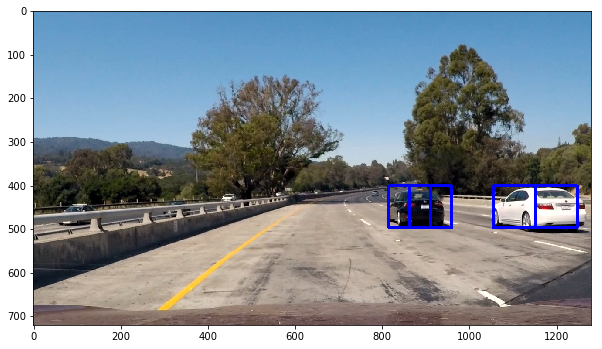

In [341]:
# Draw the rectangles onto the example image

test_img_rects = draw_boxes(test_img, rectangles, color=(0,0,255))
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


## Combine Various Sliding Window Searches

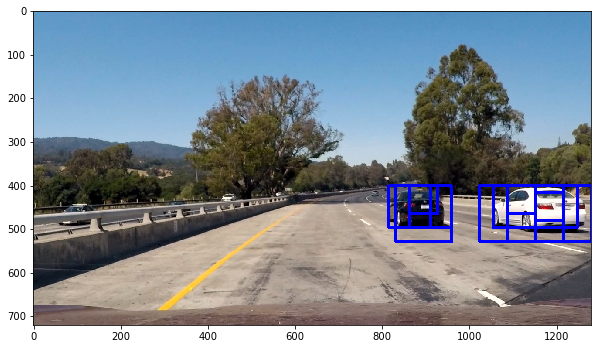

In [342]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[0]))

ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[1]))

ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[2]))

ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[3]))

ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[4]))

ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[5]))

ystart = 400
ystop = 596
scale = 3.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[6]))

ystart = 464
ystop = 660
scale = 3.0
rectangles.append(find_vehicles(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                  orient, pix_per_cell, cell_per_block, False))
#print(len(rectangles[7]))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
#test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=6)
test_img_rects = draw_boxes(test_img, rectangles, color=(0,0,255), thick=6)

plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## Heatmap

In [343]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

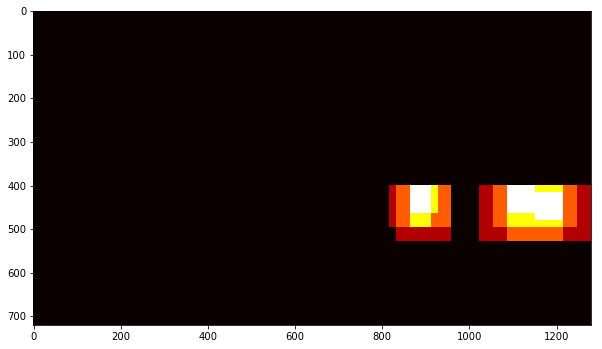

In [344]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


## Apply Threshold to the Heatmap

In [345]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

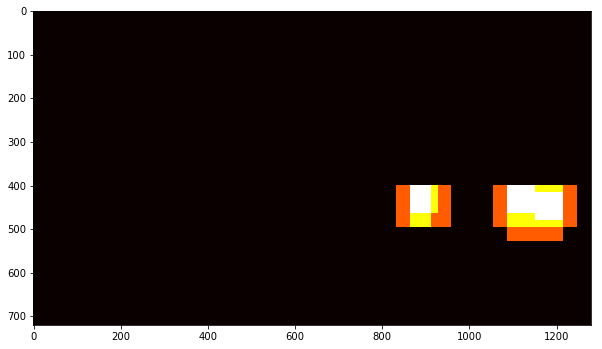

In [346]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

## Apply Labels to Thresholded Heatmap

2 vehicles found


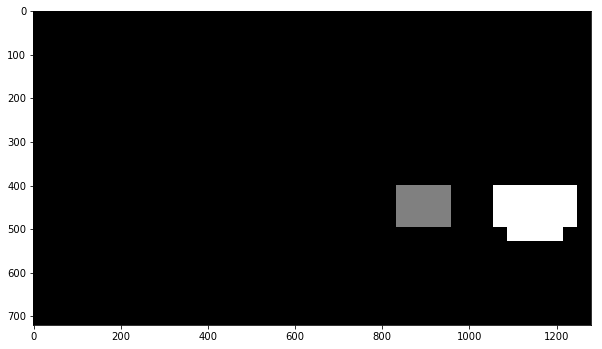

In [347]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'vehicles found')

## Draw Bounding Boxes for Lables

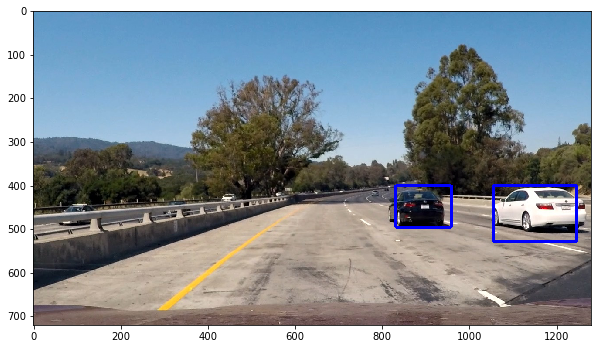

In [348]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

# Pipeline

In [349]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


## Pipeline (Test Images)

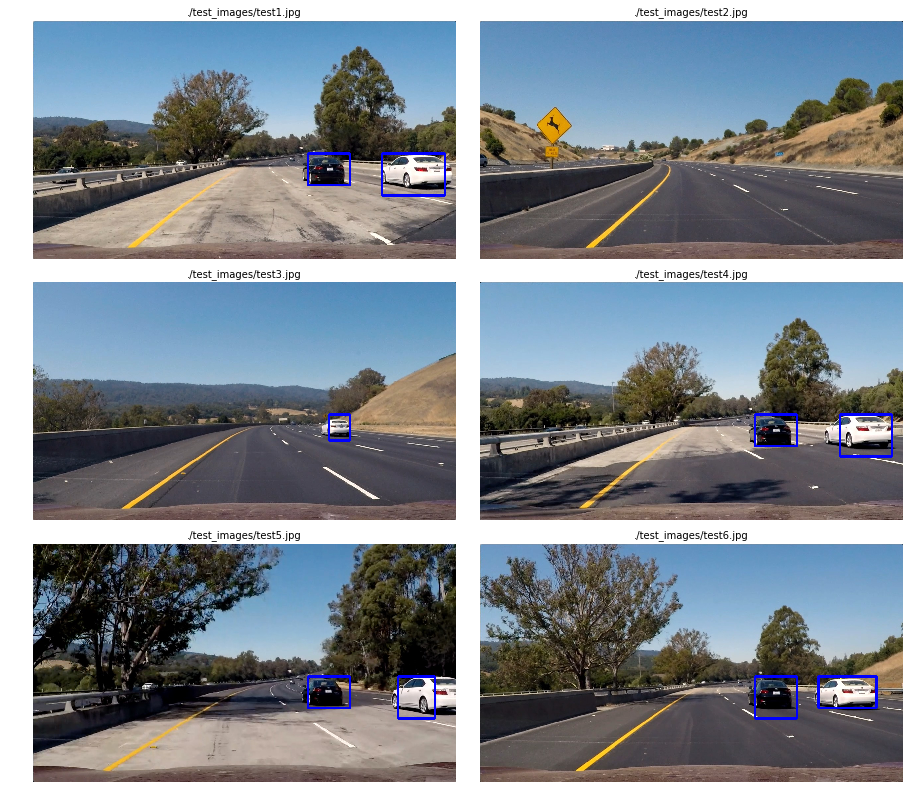

In [350]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .1, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')
    axs[i].set_title(test_images[i], fontsize=10)

#  Video

## Class to Store Data from Vehicle Detections

In [351]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


## Pipeline for Processing Video Frames

In [352]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 596
    scale = 3.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
    ystart = 464
    ystop = 660
    scale = 3.0
    rectangles.append(find_vehicles(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


## Video

In [354]:
det = Vehicle_Detect()

proj_out_file = 'project_video_output.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(10,20)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:34<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 7s, sys: 42.7 s, total: 5min 50s
Wall time: 5min 35s
